In [32]:
# Tao Path
from pathlib import Path

letters = 'qwertyuiopasdfghjklzxcvbnm'
numbers = '0123456789'
for i in list(letters + numbers):
    Path(f'data/label/{i}').mkdir(parents=True, exist_ok=True)

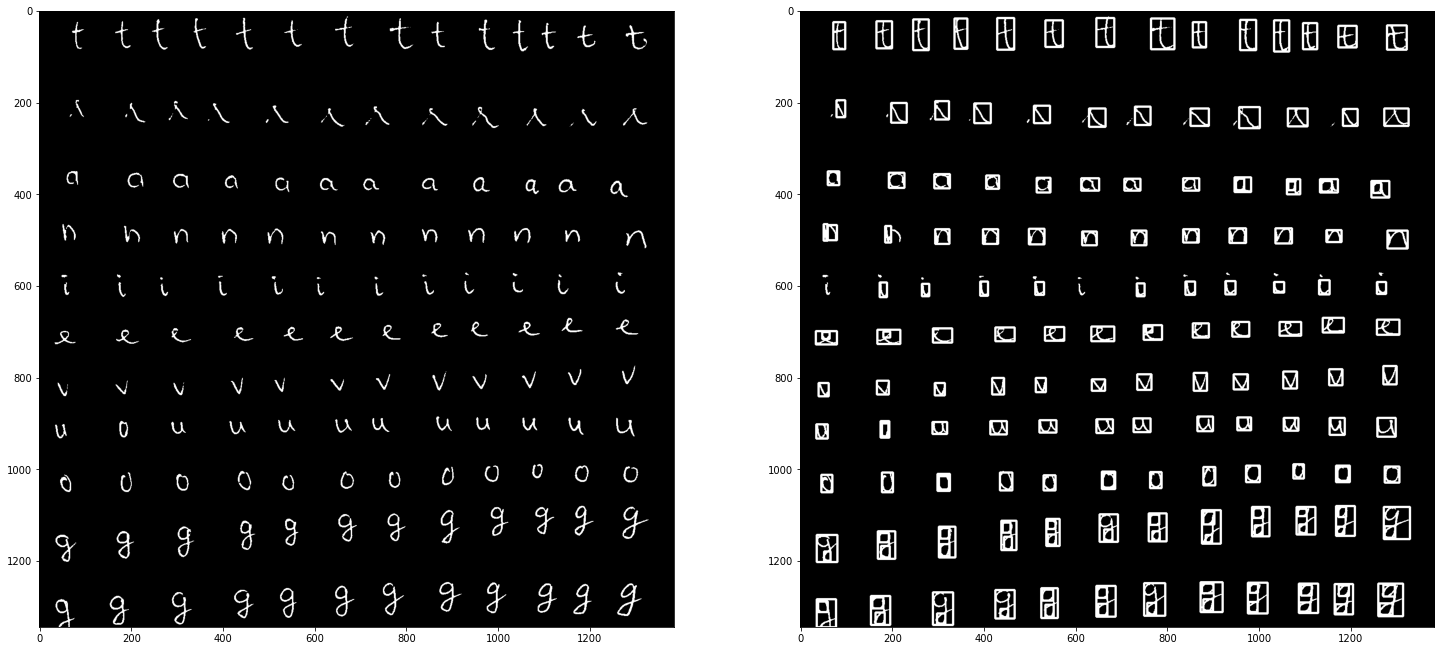

In [2]:
# Tao data
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time



img = cv2.imread('data/origin/data3.jpg', 0)
thres = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
contours = cv2.findContours(thres, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
mask_contour = thres.copy()
for c in contours:
    if cv2.contourArea(c) > 100 and cv2.contourArea(c) < 10000:
        # get the bounding rect
        x, y, w, h = cv2.boundingRect(c)
        # draw a white rectangle to visualize the bounding rect
        cv2.rectangle(mask_contour, (x, y), (x + w, y + h), 255, 3)
        path_to_save = f'data/label/{time.time()}.jpg'
        cv2.imwrite(path_to_save, thres[y:y+h, x:x+w])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
ax[0].imshow(thres, cmap="gray")
ax[1].imshow(mask_contour, cmap="gray")
plt.show()



In [4]:
arr_path_for_training = ['data/label_white_bg']
raw_data = []
for path_for_training in arr_path_for_training:
    for r,d,f in os.walk(path_for_training):
        for images in f:
            img = cv2.imread(r +"/"+ images, 0)
            img = cv2.bitwise_not(img)
            img = cv2.resize(img, (28,28))
            cv2.imwrite((r +"/"+ images).replace('label_white_bg', 'label'), img)
            

In [4]:
reverse_mapping_char = dict(enumerate("abcdefghijklmnopqrstuvwxyz1234567890"))
mapping_char = {v: k for k, v in reverse_mapping_char.items()}
print(reverse_mapping_char)
print(mapping_char)


{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: '1', 27: '2', 28: '3', 29: '4', 30: '5', 31: '6', 32: '7', 33: '8', 34: '9', 35: '0'}
{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, '1': 26, '2': 27, '3': 28, '4': 29, '5': 30, '6': 31, '7': 32, '8': 33, '9': 34, '0': 35}


In [6]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
import os
import cv2
import random
import matplotlib.pyplot as plt

# 1. data folder ----> array(list)
arr_path_for_training = ['data/label']
raw_data = []
for path_for_training in arr_path_for_training:
    for r,d,f in os.walk(path_for_training):
        for images in f:
            img = cv2.imread(r +"/"+ images, 0)
            img = cv2.resize(img, (28,28), -1)
            raw_data.append([img,mapping_char[r[-1]]])  
        
random.shuffle(raw_data)
print(len(raw_data))
# 2. list -----> to numpy ----> reshape

images_data = []
labels_data = []
totalImageForTrain = int(len(raw_data) * 0.8) # ~80% total item train 
totalImageForVal = int(len(raw_data) * 0.1) # ~10% total item train
for item in raw_data:
    images_data.append(item[0])
    labels_data.append(item[1])

images_train = np.asarray(images_data[:totalImageForTrain], dtype=np.uint8)
labels_train = np.asarray(labels_data[:totalImageForTrain], dtype=np.uint8)

images_val = np.asarray(images_data[totalImageForTrain:totalImageForTrain+totalImageForVal], dtype=np.uint8)
labels_val = np.asarray(labels_data[totalImageForTrain:totalImageForTrain+totalImageForVal], dtype=np.uint8)

images_test = np.asarray(images_data[totalImageForTrain+totalImageForVal:], dtype=np.uint8)
labels_test = np.asarray(labels_data[totalImageForTrain+totalImageForVal:], dtype=np.uint8)

# 3. Reshape lại dữ liệu cho đúng kích thước mà keras yêu cầu
images_train = images_train.reshape(images_train.shape[0], 28, 28, 1)
images_val = images_val.reshape(images_val.shape[0], 28, 28, 1)
images_test = images_test.reshape(images_test.shape[0], 28, 28, 1)

# 4. One hot encoding label (Y)
print('Dữ liệu y ban đầu ', labels_train[0])
labels_train = np_utils.to_categorical(labels_train, len(mapping_char))
labels_val = np_utils.to_categorical(labels_val, len(mapping_char))
labels_test = np_utils.to_categorical(labels_test, len(mapping_char))
print('Dữ liệu y sau one-hot encoding ',labels_train[0])

# 5. Định nghĩa model
model = Sequential()
 
# Thêm Convolutional layer với 32 kernel, kích thước kernel 3*3
# dùng hàm sigmoid làm activation và chỉ rõ input_shape cho layer đầu tiên
model.add(Conv2D(32, (3, 3), activation='sigmoid', input_shape=(28,28,1)))

# Thêm Convolutional layer
model.add(Conv2D(32, (3, 3), activation='sigmoid'))

# Thêm Max pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten layer chuyển từ tensor sang vector
model.add(Flatten())

# Thêm Fully Connected layer với 128 nodes và dùng hàm sigmoid
model.add(Dense(128, activation='sigmoid'))

# Output layer với len(mapping_char) node và dùng softmax function để chuyển sang xác xuất.
model.add(Dense(len(mapping_char) , activation='softmax'))

# 6. Compile model, chỉ rõ hàm loss_function nào được sử dụng, phương thức 
# đùng để tối ưu hàm loss function.
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
# 7. Thực hiện train model với data
model.fit(images_train, labels_train, validation_data=(images_val, labels_val),
          batch_size=32, epochs=10, verbose=1)

# 8. Lưu model
# model.save("tracuuhoadon_gdt_gov_vn_captcha_model.h5")
model.save("chu_viet_tay.h5")

# 9. Đánh giá model với dữ liệu test set
score = model.evaluate(images_test, labels_test, verbose=0)
print(score)




2311
Dữ liệu y ban đầu  4
Dữ liệu y sau one-hot encoding  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               589952    
_________________________________________________________________
dense_1 (Dense)    

Kết quả: 697


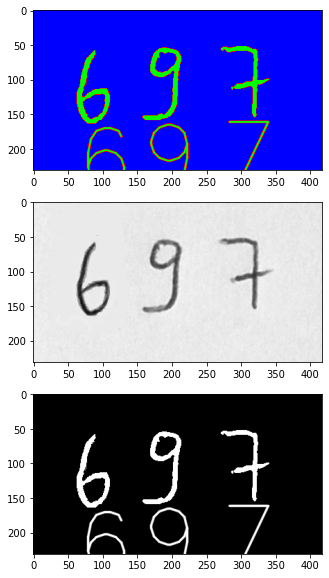

In [20]:
import keras, cv2, time
import numpy as np
import matplotlib.pyplot as plt

model = keras.models.load_model('chu_viet_tay.h5')

img = cv2.imread('data/origin/test101.jpg', 0)
thres = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
contours = cv2.findContours(thres, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
img_contours = thres.copy()
result = []
for c in contours:
    if cv2.contourArea(c) > 300:
        # get the bounding rect
        x, y, w, h = cv2.boundingRect(c)
        # add bounding rectangle
        result.append({
            'start_x': x,
            'start_y': y,
            'end_x': x + w,
            'end_y': y + h,
        })

# sort left => right
result = sorted(result, key=lambda k: (k['start_x'])) 
# Only keep biggest contours - Main character
letter = []
result_string = ""
# fig, ax = plt.subplots(nrows=1, ncols=len(result), figsize=(25, 25))
for i in range(len(result)):
    letter.append(img_contours[result[i]['start_y']: result[i]['end_y'], result[i]['start_x'] : result[i]['end_x']])
    
    # path_to_save = f'data/label/{time.time()}.jpg'
    # cv2.imwrite(path_to_save, letter[i])
    letter[i] = cv2.resize(letter[i], (28,28))
    
    # predict
    predict_char_val = np.argmax(model.predict(letter[i].reshape(1, 28, 28, 1)))
    predict_char = reverse_mapping_char[predict_char_val]
    result_string += predict_char
    
    # Put Text
    # cv2.rectangle(thres, (result[i]['start_x'], result[i]['start_y']), (result[i]['end_x'], result[i]['end_y']), 50, 2)
    x, y = result[i]['start_x'], (result[i]['start_y'] - 35 if  result[i]['start_y'] - 35 > 50 else result[i]['end_y'] + 90)
    textFill, org, font, fontScale, color, thickness = predict_char, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 4, (255, 0, 0), 2
    cv2.putText(thres, textFill, org, font, fontScale, color, thickness, cv2.LINE_AA)
    
    # pyplot
    # ax[i].imshow(letter[i], cmap="gray")

# plt.show()
print('Kết quả:', result_string)
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))
ax[0].imshow(thres, cmap="brg")
ax[1].imshow(img, cmap="gray")
ax[2].imshow(thres, cmap="gray")
plt.show()

In [ ]:
import keras, cv2, time
import numpy as np
import matplotlib.pyplot as plt

model = keras.models.load_model('chu_viet_tay.h5')

img = cv2.imread('data/origin/test101.jpg', 0)
thres = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
contours = cv2.findContours(thres, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
img_contours = thres.copy()
result = []
for c in contours:
    if cv2.contourArea(c) > 300:
        # get the bounding rect
        x, y, w, h = cv2.boundingRect(c)
        # add bounding rectangle
        result.append({
            'start_x': x,
            'start_y': y,
            'end_x': x + w,
            'end_y': y + h,
        })

# sort left => right
result = sorted(result, key=lambda k: (k['start_x'])) 
# Only keep biggest contours - Main character
letter = []
result_string = ""
# fig, ax = plt.subplots(nrows=1, ncols=len(result), figsize=(25, 25))
for i in range(len(result)):
    letter.append(img_contours[result[i]['start_y']: result[i]['end_y'], result[i]['start_x'] : result[i]['end_x']])
    
    # path_to_save = f'data/label/{time.time()}.jpg'
    # cv2.imwrite(path_to_save, letter[i])
    letter[i] = cv2.resize(letter[i], (28,28))
    
    # predict
    predict_char_val = np.argmax(model.predict(letter[i].reshape(1, 28, 28, 1)))
    predict_char = reverse_mapping_char[predict_char_val]
    result_string += predict_char
    
    # Put Text
    # cv2.rectangle(thres, (result[i]['start_x'], result[i]['start_y']), (result[i]['end_x'], result[i]['end_y']), 50, 2)
    x, y = result[i]['start_x'], (result[i]['start_y'] - 35 if  result[i]['start_y'] - 35 > 50 else result[i]['end_y'] + 90)
    textFill, org, font, fontScale, color, thickness = predict_char, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 4, (255, 0, 0), 2
    cv2.putText(thres, textFill, org, font, fontScale, color, thickness, cv2.LINE_AA)
    
    # pyplot
    # ax[i].imshow(letter[i], cmap="gray")

# plt.show()
print('Kết quả:', result_string)
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))
ax[0].imshow(thres, cmap="brg")
ax[1].imshow(img, cmap="gray")
ax[2].imshow(thres, cmap="gray")
plt.show()